In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
file_names = {
    "train": "setting/data_train.xlsx",
    "test": "setting/data_test.xlsx",
    "val": "setting/data_val.xlsx",
    
    "lf_train": "setting/lf_train.xlsx",
    "lf_test": "setting/lf_test.xlsx",
    "lf_val": "setting/lf_val.xlsx",    
}

In [3]:
data_train = pd.read_excel(file_names["train"], index_col=0).sample(frac=1, random_state=2023).reset_index()
data_val = pd.read_excel(file_names["val"], index_col=0).reset_index()
data_test = pd.read_excel(file_names["test"], index_col=0).reset_index()

data_train["label"] = data_train["Final decision"].apply(lambda x: int("include" in x.lower()))
data_val["label"] = data_val["Final decision"].apply(lambda x: int("include" in x.lower()))
data_test["label"] = data_test["Final decision"].apply(lambda x: int("include" in x.lower()))

<AxesSubplot: >

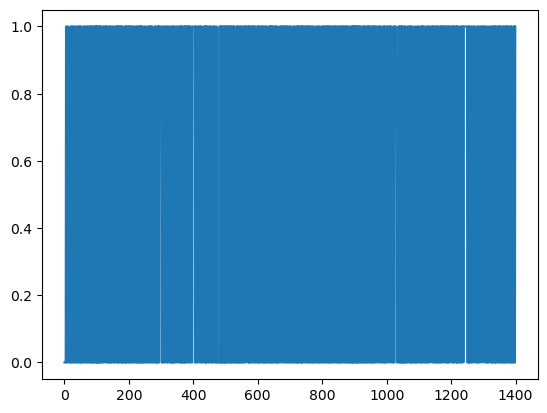

In [4]:
data_train["label"].plot()

In [5]:
lf_train = pd.read_excel(file_names["lf_train"], index_col=0).reset_index()
lf_val = pd.read_excel(file_names["lf_val"], index_col=0).reset_index()
lf_test = pd.read_excel(file_names["lf_test"], index_col=0).reset_index()

In [6]:
lf_train = lf_train.set_index("index").loc[data_train["index"]].reset_index()
lf_test = lf_test.set_index("index").loc[data_test["index"]].reset_index()
lf_val = lf_val.set_index("index").loc[data_val["index"]].reset_index()

In [7]:
rel_cols = ['CH4',
 'GHG',
 'N2O',
 'agricultural',
 'agriculture',
 'agroforestry',
 'agroforestry systems',
 'bio*',
 'carbon',
 'change',
 'climate',
 'conservation',
 'conventional',
 'cover',
 'crop',
 'economy',
 'emission',
 'emission*',
 'emissions',
 'experiment',
 'fallow',
 'farm',
 'farms',
 'gas',
 'global warm*',
 'greenhouse',
 'higher',
 'impact',
 'impact of',
 'increas*',
 'integrate*',
 'intensification',
 'intercropping',
 'intercropping systems',
 'livestock',
 'lower',
 'methane',
 'mitig*',
 'model',
 'net',
 'nitr*',
 'organic',
 'potential',
 'practices',
 'productivity',
 'rainfed',
 'reduc*',
 'rice',
 'scenario',
 'seasonal',
 'significantly',
 'social',
 'soil',
 'soils',
 'soybean',
 'storage',
 'synthetic',
 'system',
 'systems',
 'till',
 'tillage',
 'water']

In [8]:
%%capture
!pip install transformers
!pip install datasets
!pip install torch

In [9]:
from transformers import BertTokenizer, BertModel
import torch

In [10]:
model_name = "bert-base-cased"
bert_model = BertModel.from_pretrained(model_name)
bert_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
e = bert_model.eval()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
bert_tokenizer.all_special_tokens, bert_tokenizer.all_special_ids

(['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'], [100, 102, 0, 101, 103])

In [12]:
from torch.utils.data import Dataset
class DatasetTaskDecision(Dataset):
    def __init__(self, df, df_lf, maxlen_ab=510):
        self.df = df
        self.df_lf = df_lf
        self.tokenizer = bert_tokenizer
        self.maxlen_ab = maxlen_ab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sentence2 = str(self.df.loc[index, 'Abstract (AB)'])

        label = int(self.df.loc[index, "label"])
        
        tokens2 = self.tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens2) <= self.maxlen_ab:
            tokens2 = tokens2 + ['[PAD]' for _ in range(self.maxlen_ab - len(tokens2))]
        else:
            tokens2 = tokens2[:self.maxlen_ab]
    
          
        tokens = ["[CLS]"]+tokens2+["[SEP]"]
        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 0).long() # [PAD] => 0
        
        lf_tensor = torch.tensor(self.df_lf.loc[index, :].values)

        return lf_tensor, tokens_ids_tensor, attn_mask, label

In [13]:
from torch.utils.data import DataLoader

train_set = DatasetTaskDecision(df = data_train, df_lf = lf_train[rel_cols])
val_set = DatasetTaskDecision(df = data_test, df_lf = lf_test[rel_cols])

train_loader = DataLoader(train_set, batch_size = 16, num_workers = 2, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 16, num_workers = 2, shuffle=False)

In [15]:
len(rel_cols)

62

In [16]:
import torch.nn as nn
class DecisionClassifier(nn.Module):
    def __init__(self):
        super(DecisionClassifier, self).__init__()
        torch.manual_seed(2023)
        
        self.bert_layer = BertModel.from_pretrained(model_name).cuda()
        self.cls_layer = nn.Linear(768+62, 2).cuda()

    def forward(self, lfs, seq, attn_masks):

        cont_reps = self.bert_layer(seq, attention_mask=attn_masks)
        
        cls_rep = cont_reps.last_hidden_state[:, 0]
        lfs = lfs.to(cls_rep.dtype)
        cls_rep = torch.cat((lfs,cls_rep), 1)

        logits = self.cls_layer(cls_rep)

        return logits

In [17]:
import torch.optim as optim

net = DecisionClassifier()

weights = torch.tensor([1., 1.0114]) # 6.5])
criterion = nn.CrossEntropyLoss(weight=weights, reduction='mean').cuda()

opti = optim.Adam(net.parameters(), lr = 2e-5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    soft_probs = probs.argmax(1)
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc
    
def evaluate(net, criterion, dataloader):
    net.eval()
    mean_acc, mean_loss = 0, 0
    count = 0
    with torch.no_grad():
        for lfs, seq, attn_masks, labels in dataloader:
            lfs, seq, attn_masks, labels = lfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(lfs, seq, attn_masks)
            mean_loss += criterion(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def evaluate_precision_recall_fscore_support(net, dataloader):
    net.eval()
    preds = []
    tests = []
    with torch.no_grad():
        for lfs, seq, attn_masks, labels in dataloader:
            lfs, seq, attn_masks, labels = lfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()
            logits = net(lfs, seq, attn_masks)
            probs = torch.sigmoid(logits)
            # soft_probs = probs.argmax(1)
            soft_probs = probs[:, 0] <0.5
            preds += soft_probs.squeeze().tolist()
            tests += labels.tolist()
    return tests, preds

In [19]:
def train(net, criterion, opti, train_loader, val_loader, epochs):
    for ep in range(epochs):
        for it, (lfs, seq, attn_masks, labels) in enumerate(train_loader):
            opti.zero_grad()  

            lfs, seq, attn_masks, labels = lfs.cuda(), seq.cuda(), attn_masks.cuda(), labels.cuda()

            logits = net(lfs, seq, attn_masks)

            loss = criterion(logits, labels)

            loss.backward()

            opti.step()

            if (it + 1) % 100 == 0:
                acc = get_accuracy_from_logits(logits, labels)
                # tests, preds = evaluate_precision_recall_fscore_support(net, train_loader)
                # print(classification_report(tests, preds))
                print("Iteration {} of epoch {} complete. Loss : {} Train Accuracy : {}".format(it+1, ep+1, loss.item(), acc))
        val_acc, val_loss = evaluate(net, criterion, val_loader)
        tests, preds = evaluate_precision_recall_fscore_support(net, val_loader)
        print(classification_report(tests, preds, digits=4))
        print("Epoch {} complete! Validation Accuracy : {}, Validation Loss : {}".format(ep+1, val_acc, val_loss))

In [25]:
epochs = 5
train(net, criterion, opti, train_loader, val_loader, epochs)

              precision    recall  f1-score   support

           0     0.8636    0.5053    0.6376       188
           1     0.6793    0.9292    0.7849       212

    accuracy                         0.7300       400
   macro avg     0.7715    0.7173    0.7112       400
weighted avg     0.7659    0.7300    0.7156       400

Epoch 1 complete! Validation Accuracy : 0.7224999666213989, Validation Loss : 1.1114261376857757


In [26]:
from huggingface_hub import notebook_login

In [1]:
notebook_login()

In [28]:
!git config --global credential.helper store

In [1]:
repo_name = "bert_lf_abstract"
net.bert_layer.push_to_hub(repo_name)

In [2]:
val_set.tokenizer.push_to_hub(repo_name)

In [32]:
torch.save(net.cls_layer, "cls_layer.torch")

In [33]:
from huggingface_hub import hf_hub_url, cached_download

In [3]:
repo_name = "bert_lf_abstract"
config_file_url = hf_hub_url("X/"+repo_name, filename="cls_layer.torch")
value = cached_download(config_file_url)
cls_layer = torch.load(value)

In [35]:
bert_model = BertModel.from_pretrained("X/"+repo_name).cuda()
bert_tokenizer = BertTokenizer.from_pretrained("X/"+repo_name, do_lower_case=False)
e = bert_model.eval()

In [36]:
def preproccesing(ab, maxlen=510):
        sentence2 = str(ab)
        tokens2 = bert_tokenizer.tokenize(sentence2) if len(sentence2)>0 else ["[UNK]"]

        if len(tokens2) < maxlen:
            tokens2 = tokens2 + ['[PAD]' for _ in range(maxlen - len(tokens2))]
        else:
            tokens2 = tokens2[:maxlen]
          
        tokens = ["[CLS]"]+tokens2+["[SEP]"]
        # tokens = [x for x in tokens if x!="[PAD]"]
        tokens_ids = bert_tokenizer.convert_tokens_to_ids(tokens)
        tokens_ids_tensor = torch.tensor(tokens_ids)
        attn_mask = (tokens_ids_tensor != 0).long() # [PAD] => 0

        return tokens_ids_tensor.cuda(), attn_mask.cuda()

In [37]:
def DecisionClassifier(lfs, ab):
    tokens_ids_tensor, attn_mask = preproccesing(ab)
    cont_reps = bert_model(tokens_ids_tensor.unsqueeze(0), attention_mask = attn_mask.unsqueeze(0))
    cls_rep = cont_reps.last_hidden_state[:, 0]
    lfs = torch.tensor(lfs).cuda()
    lfs = lfs.to(cls_rep.dtype).unsqueeze(0)
    cls_rep = torch.cat((lfs,cls_rep), 1)
    logits = cls_layer(cls_rep)
    probs = torch.sigmoid(logits)
    return probs.detach().cpu().numpy()[0]

In [38]:
i = 0
ab = data_train.iloc[i]["Abstract (AB)"]
lfs = lf_train.iloc[i][rel_cols]
print(data_train.iloc[i]["Final decision"], ab)
DecisionClassifier(lfs, ab)

EXCLUDE Rising global energy needs and limited fossil fuel reserves have led to increased use of renewable energies. In Germany, this has entailed massive exploitation of agricultural biomass for biogas generation, associated with unsustainable farming practices. Organic agriculture not only reduces negative environmental impacts, organic farmers were also prime movers in anaerobic digestion (AD) in Germany. This study's aim was to identify the structure, development, and characteristics of biogas production associated with organic farming systems in order to estimate further development, as well as energetic and associated agronomic potentials. Surveys were conducted among organic farms with AD technology. 144 biogas plants could be included in the analysis. Total installed electrical capacity was 30.8 MWel, accounting for only 0.8% of the total installed electrical capacity in the German biogas sector. Recently, larger plant types (>250 kW(el)) with increased use of (also purchased) 

array([0.97568226, 0.034503  ], dtype=float32)

In [39]:
from sklearn.metrics import classification_report

In [36]:
# %%time
# y_pred = [ int(
#     DecisionClassifier(
#         ab=data_train.iloc[i]["Abstract (AB)"]
#         )[0]<0.5) 
#     for i in range(data_train.shape[0])
# ]
# report = classification_report(data_train["label"], y_pred, output_dict=True)
# train_report = pd.DataFrame(report)
# train_report

In [37]:
# pickle.dump(y_pred, open("y_pred_train_beto_vanilla_abstract.pickle", "wb"))

In [38]:
# %%time
# y_pred = [ int(
#     DecisionClassifier(
#         ab=data_val.iloc[i]["Abstract (AB)"]
#         )[0]<0.5) 
#     for i in range(data_val.shape[0])
# ]
# report = classification_report(data_val["label"], y_pred, output_dict=True)
# val_report = pd.DataFrame(report)
# val_report

In [39]:
# pickle.dump(y_pred, open("y_pred_val_beto_vanilla_abstract.pickle", "wb"))

In [40]:
%%time
y_pred = [ int(
    DecisionClassifier(
        ab=data_test.iloc[i]["Abstract (AB)"],
        lfs=lf_test.iloc[i][rel_cols]
        )[0]<0.5) 
    for i in range(data_test.shape[0])
]
report = classification_report(data_test["label"], y_pred, output_dict=True)
test_report = pd.DataFrame(report)
test_report

CPU times: user 5.2 s, sys: 3.93 ms, total: 5.2 s
Wall time: 5.2 s


,0,1,accuracy,macro avg,weighted avg
precision,0.863636,0.679310,0.73,0.771473,0.765944
recall,0.505319,0.929245,0.73,0.717282,0.730000
f1-score,0.637584,0.784861,0.73,0.711222,0.715641
support,188.000000,212.000000,0.73,400.000000,400.000000


In [41]:
print(classification_report(data_test["label"], y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8636    0.5053    0.6376       188
           1     0.6793    0.9292    0.7849       212

    accuracy                         0.7300       400
   macro avg     0.7715    0.7173    0.7112       400
weighted avg     0.7659    0.7300    0.7156       400



In [42]:
pickle.dump(y_pred, open("y_pred_test_beto_lf_abstract.pickle", "wb"))